# SingleLabelDAprediciton(SwDA)

In [48]:
import time
import os
import pyhocon
import torch
import argparse
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import glob
import os, re, json
import matplotlib.pyplot as plt
import jsonlines
import random
import torch.nn.functional as F
import math
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')

## データ前処理

In [3]:
EOS_token = '<EOS>'
BOS_token = '<BOS>'
file_pattern = re.compile(r'^sw\_([a-z]+?)\_([0-9]+?)\.jsonlines$')

swda_tagu = {
    '<Uninterpretable>': ['abandoned_or_turn-exit/uninterpretable', 'non-verbal'],
    '<Statement>': ['statement-non-opinion', 'statement-opinion', 'other_answers', '3rd-party-talk', 'self-talk', 'offers,_options_commits', 'collaborative_completion'],
    '<Question>': ['q', 'yes-no-question', 'wh-question', 'declarative_yes-no-question', 'backchannel_in_question_form', 'open-question', 'rhetorical-questions', 'signal-non-understanding', 'or-clause', 'tag-question', 'declarative_wh-question'],
    '<Directive>': ['action-directive'],
    '<Greeting>': ['conventional-opening', 'conventional-closing'],
    '<Apology>': ['apology', 'no_answers', 'reject', 'negative_non-no_answers', 'dispreferred_answers', 'dispreferred_answers'],
    '<Agreement>': ['agree/accept', 'maybe/accept-part', 'thanking'],
    '<Understanding>': ['acknowledge_(backchannel)', 'summarize/reformulate', 'appreciation', 'response_acknowledgement', 'affirmative_non-yes_answers', 'yes_answers'],
    '<Other>': ['other', 'hedge', 'quotation', 'repeat-phrase', 'hold_before_answer/agreement', 'downplayer']
}

daily_tagu = {1: "inform", 2: "question", 3: "directive", 4: "commissive"}

### 対話行為のID化

In [4]:
class DA_to_ID:
    
    def __init__(self, config, X_DA, Y_DA, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_DA = X_DA
        self.Y_DA = Y_DA
        self.name = name
        self.construct()
        
    def construct(self):
#        vocab = {'<PAD>': 0}
        vocab = {}
        vocab_count = {}
        
        for x,y in zip(self.X_DA, self.Y_DA):
            for token in x:
                if token in vocab_count:
                    vocab_count[token] += 1
                else:
                    vocab_count[token] = 1
                    
            for token in y:
                if token in vocab_count:
                    vocab_count[token] += 1
                else:
                    vocab_count[token] = 1
                    
        for k, _ in sorted(vocab_count.items(), key=lambda x: -x[1]):
            vocab[k] = len(vocab)
            if len(vocab) >= self.config[self.name]['MAX_VOCAB']: break
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}
        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        X_Tensor = [[self.word2id[token] for token in sentence] for sentence in X_tensor]
        Y_Tensor = [[self.word2id[token] for token in sentence] for sentence in Y_tensor]
        return X_Tensor, Y_Tensor

### 発話のID化

In [5]:
class UTT_to_ID:
    
    def __init__(self, config, X_UTT, Y_UTT, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_UTT = X_UTT
        self.Y_UTT = Y_UTT
        self.name = name
        self.construct()
        
    def construct(self):
        
        vocab = {'<UNK>': 0, '<EOS>': 1, '<BOS>': 2, '<UttPAD>': 3, '<ConvPAD>': 4}
        vocab_count = {}
        
        for x,y in zip(self.X_UTT, self.Y_UTT):
            for seq in x:
                for word in seq:
                    if word in vocab_count:
                        vocab_count[word] += 1
                    else:
                        vocab_count[word] = 1
            for seq in y:
                for word in seq:
                    if word in vocab_count:
                        vocab_count[word] += 1
                    else:
                        vocab_count[word] = 1
                        
        for k, _ in sorted(vocab_count.items(), key=lambda x: -x[1]):
            vocab[k] = len(vocab)
            if len(vocab) >= self.config[self.name]['UTT_MAX_VOCAB']: break
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}

        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        
        X_Tensor = [[[self.word2id[token] if token in self.word2id else self.word2id['<UNK>'] for token in seq] for seq in dialogue] for dialogue in X_tensor]
        Y_Tensor = [[[self.word2id[token] if token in self.word2id else self.word2id['<UNK>'] for token in seq] for seq in dialogue] for dialogue in Y_tensor]
        return X_Tensor, Y_Tensor

### トレーニングデータ作成

In [6]:
def create_traindata(config, name):
    files = [f for f in os.listdir(config[name]['train_path']) if file_pattern.match(f)]
    # print("files:" , files)
    da_x, da_y, utt_x, utt_y, turn = [], [], [], [], []
    # 1file 1conversation
    for filename in files:
        # print(os.path.join(config['train_path'], filename))
        with open(os.path.join(config[name]['train_path'], filename), 'r') as f:
            data = f.read().split('\n')
            data.remove('')
            da_seq, utt_seq, turn_seq = [], [], []
            # 1line 1turn
            for idx, line in enumerate(data, 1):
                jsondata = json.loads(line)
                # single-turn multi dialogue case
                if config[name]['multi_dialogue']:
                    for da, utt in zip(jsondata['DA'], jsondata['sentence']):
                        da_seq.append(da)
                        utt_seq.append(utt.split(' '))
                        turn_seq.append(0)
                    if config[name]['turn']:
                        da_seq.append('<turn>')
                        utt_seq.append('<turn>')
                    turn_seq[-1] = 1
                # single-turn single dialogue case
                else:
                    da_seq.append(jsondata['DA'][-1])
                    utt_seq.append(jsondata['sentence'][-1].split(' '))
#             da_seq = [easy_damsl(da) for da in da_seq]
            
            # assert len(turn_seq) == len(da_seq), '{} != {}'.format(len(turn_seq), len(da_seq))
        if config[name]['state']:
            for i in range(max(1, len(da_seq) - 1 - config[name]['window_size'])):
                da_x.append(da_seq[i:min(len(da_seq)-1, i + config[name]['window_size'])])
                da_y.append(da_seq[1 + i:min(len(da_seq), 1 + i + config[name]['window_size'])])
                utt_x.append(utt_seq[i:min(len(da_seq)-1, i + config[name]['window_size'])])
                utt_y.append(utt_seq[1 + i:min(len(da_seq), 1 + i + config[name]['window_size'])])
                turn.append(turn_seq[i:min(len(da_seq), i + config[name]['window_size'])])
        else:
            da_x.append(da_seq[:-1])
            da_y.append(da_seq[1:])
            utt_x.append(utt_seq[:-1])
            utt_y.append(utt_seq[1:])
            turn.append(turn_seq[:-1])
    assert len(da_x) == len(da_y), 'Unexpect length da_posts and da_cmnts'
    assert len(utt_x) == len(utt_y), 'Unexpect length utt_posts and utt_cmnts'
    # assert len(turn) == len(da_posts)
    
    return da_x, da_y, utt_x, utt_y, turn


In [7]:
def easy_damsl(tag):
    easy_tag = [k for k, v in swda_tagu.items() if tag in v]
    return easy_tag[0] if not len(easy_tag) < 1 else tag

def separate_data(x, y, turn):
    split_size = round(len(x) / 10)
    if split_size == 0: split_size = 1
    X_train, Y_train, Tturn = x[split_size * 2:], y[split_size * 2:], turn[split_size * 2:]
    X_valid, Y_valid, Vturn = x[split_size: split_size * 2], y[split_size: split_size * 2], turn[split_size: split_size * 2]
    X_test, Y_test, Testturn = x[:split_size], y[:split_size], turn[:split_size]
    assert len(X_train) == len(Y_train), 'Unexpect to separate train data'
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn

In [8]:
def initialize_env(name):
    config = pyhocon.ConfigFactory.parse_file('./dialogue.conf')
    config['log_dirs'] = os.path.join(config[name]['log_dir'])
    if not os.path.exists(config['log_dirs']):
        os.mkdir(config['log_dirs'])
     
    return config

def create_DAdata(config, name):
    posts, cmnts, _, _, turn = create_traindata(config, name)
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn = separate_data(posts, cmnts, turn)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn

def create_Uttdata(config, name):
    _, _, posts, cmnts, turn = create_traindata(config, name)
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, _, _, _ = separate_data(posts, cmnts, turn)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test


In [9]:
model_name = "CmbAttention"
loss_name = "CE"

In [10]:
write = SummaryWriter("./logs")
config = initialize_env(model_name+loss_name)

XDA_train, YDA_train, XDA_valid, YDA_valid, _, _, Tturn, Vturn, _ = create_DAdata(config, model_name+loss_name)
XUtt_train, YUtt_train, XUtt_valid, YUtt_valid, _, _ = create_Uttdata(config, model_name+loss_name)

DA_vocab = DA_to_ID(config, XDA_train+XDA_valid, YDA_train+YDA_valid, model_name+loss_name)
Utt_vocab = UTT_to_ID(config, XUtt_train+XUtt_valid, YUtt_train+YUtt_valid, model_name+loss_name)

XDA_train, YDA_train = DA_vocab.tokenize(XDA_train, YDA_train)
XDA_valid, YDA_valid = DA_vocab.tokenize(XDA_valid, YDA_valid)
XUtt_train, YUtt_train = Utt_vocab.tokenize(XUtt_train, YUtt_train)
XUtt_valid, YUtt_valid = Utt_vocab.tokenize(XUtt_valid, YUtt_valid)

print('Finish preparing dataset...')

Finish preparing dataset...


In [11]:
XDA_valid = list(filter(None, XDA_valid))
YDA_valid = list(filter(None, YDA_valid))
XUtt_valid = list(filter(None, XUtt_valid))
YUtt_valid = list(filter(None, YUtt_valid))

## Model

In [12]:
class CmbAttentionModel(nn.Module):
    
    def __init__(self, model_name, utt_vocab, da_vocab, config, device):
        super(CmbAttentionModel, self).__init__()
        
        self.utter_encoder = UtteraceEncoder(len(utt_vocab.word2id), config[model_name]['UTT_EMBED'], config[model_name]['UTT_HIDDEN'])

        self.context_encoder = RNNContextAwareEncoder(config[model_name]['CON_EMBED'], config[model_name]['CON_HIDDEN'])

#         self.da_encoder = RNNDAAwareEncoder(len(utt_vocab.word2id), config[model_name]['DA_EMBED'], config[model_name]['DA_HIDDEN'])

        self.de_encoder = DenceEncoder(config[model_name]['DA_HIDDEN'], config[model_name]['DA_EMBED'], len(da_vocab.word2id))

        self.device = device
        
    def forward(self, X_utter, X_da, Y_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)
        
        Y_da = Y_da.squeeze()
        
        return output, utter_hidden, context_hidden, da_hidden
    
    def validtion(self, X_utter, X_da, Y_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)
            
        Y_da = Y_da.squeeze(0)

        return output, utter_hidden, context_hidden, da_hidden, Y_da


    def prediction(self, X_utter, X_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)

        return output, utter_hidden, context_hidden, da_hidden, utter_weights


    def initDAHidden(self, batch_size):
        return self.utter_encoder.initHidden(batch_size, self.device), self.context_encoder.initHidden(batch_size, self.device), self.da_encoder.initHidden(batch_size, self.device)

### Model Block

In [13]:
class WordEmbedding(nn.Module):

    def __init__(self, vocab_size, embed_size, w_model):
        super(WordEmbedding, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, w_model)

    def forward(self, x_word):
        return torch.tanh(self.linear(self.word_embedding(x_word)))

In [14]:
class DAEmbedding(nn.Module):

    def __init__(self, da_size, embed_size, d_model):
        super(DAEmbedding, self).__init__()
        self.da_embedding = nn.Embedding(da_size, embed_size)
        self.linear = nn.Linear(embed_size, d_model)

    def forward(self, x_da):
        return torch.tanh(self.linear(self.da_embedding(x_da)))

In [15]:
class Attention(nn.Module):

    def __init__(self, d_model):
        super(Attention, self).__init__()
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.d_k = d_model
       
    def forward(self, q, k, v, mask=None):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)
        
        # ここでmaskを計算
        if mask is not None:
            mask = mask.unsqueeze(1)
            weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        attention_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(attention_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, attention_weights

In [16]:
class ContextAttention(nn.Module):

    def __init__(self, d_model, hidden_size, att_size):
        super(ContextAttention, self).__init__()
        self.q_linear = nn.Linear(att_size, att_size)
        self.v_linear = nn.Linear(att_size, att_size)
        self.k_linear = nn.Linear(att_size, att_size)

        self.fc_1 = nn.Linear(d_model, d_model)
        self.fc_3 = nn.Linear(hidden_size, d_model, bias=True)
        self.fc_2 = nn.Linear(d_model, att_size)

        self.fc_out = nn.Linear(att_size, hidden_size, bias=True)
        self.d_k = att_size

    def forward(self, x, mask, hidden):
        
        x = self.fc_2(torch.tanh(self.fc_1(x) + self.fc_3(hidden)))

        q = self.q_linear(x)
        v = self.v_linear(x)
        k = self.k_linear(x)

        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        if mask is not None:
            mask = mask.unsqueeze(1)
            weights = weights.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(weights, dim=-1)

        att_output = torch.matmul(attention_weights, v)

        output = self.fc_out(att_output)

        return output, attention_weights

In [17]:
class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):

        x = self.linear_1(x)

        x = self.dropout(F.relu(x))

        x = self.linear_2(x)

        return x

In [18]:
class PositinalEncoding(nn.Module):

    def __init__(self, d_model, max_len, dropout=0.1):
        super(PositinalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)


In [19]:
class DenceEncoder(nn.Module):
    def __init__(self, da_hidden, da_embed_size, da_input_size):
        super(DenceEncoder, self).__init__()
        self.he = nn.Linear(da_hidden, da_embed_size)
        self.ey = nn.Linear(da_embed_size, da_input_size)

    def forward(self, hidden):
        pred = self.ey(torch.tanh(self.he(hidden)))
        return pred


In [20]:
class RNNContextAwareEncoder(nn.Module):
    
    def __init__(self, emb_dim, d_model):
        super(RNNContextAwareEncoder, self).__init__()
        self.d_model = d_model
        self.linear = nn.Linear(self.d_model+1, self.d_model)
        self.rnn = nn.GRU(self.d_model, self.d_model, batch_first=True)
        self.attention = ContextAttention(self.d_model, self.d_model, self.d_model)
        self.ffn = FeedForward(self.d_model, self.d_model)

    def forward(self, x, mask, hidden):

        lin_output = self.linear(x)

        att_output, att_weights = self.attention(lin_output, mask, hidden.transpose(0,1))        

        rnn_output, rnn_hidden = self.rnn(att_output, hidden)

        ffn_output = self.ffn(rnn_output)

        return ffn_output, att_weights, rnn_hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [21]:
class RNNDAAwareEncoder(nn.Module):

    def __init__(self, da_size, emb_dim, d_model):
        super(RNNDAAwareEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = DAEmbedding(da_size, emb_dim, self.d_model)
        self.rnn = nn.GRU(self.d_model, self.d_model, batch_first=True)
        self.attention = ContextAttention(self.d_model, self.d_model, self.d_model)
        self.ffn = FeedForward(self.d_model, emb_dim)

    def forward(self, X_da, mask, hidden):

        emb_output = self.embedding(X_da)

        att_output, att_weights = self.attention(emb_output, mask, hidden.transpose(0,1))        

        rnn_output, rnn_hidden = self.rnn(att_output, hidden)

        ffn_output = self.ffn(rnn_output)

        return ffn_output, att_weights, rnn_hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [22]:
class UtteraceEncoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, d_model):
        super(UtteraceEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = WordEmbedding(vocab_size, emb_dim, self.d_model)
        self.pe = PositinalEncoding(self.d_model, 200)
        self.att = Attention(self.d_model)
        self.ffn = FeedForward(d_model, emb_dim)
        
    def forward(self, x_utter, mask):

        emb_output = self.embedding(x_utter)

        pos_output = self.pe(emb_output)

        att_output, att_weights = self.att(pos_output, pos_output, pos_output, mask)

        ffn_output = self.ffn(att_output)

        seq_len = ffn_output.size()[1]

        avg_output = F.avg_pool2d(ffn_output, (seq_len, 1)) # => (128, 1, 512)

        return avg_output, att_weights  # 発話ベクトル(128, 1, 512)

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

## モデル設定

In [51]:
len(Utt_vocab.id2word), len(DA_vocab.id2word)

(20000, 42)

In [23]:
lr = config[model_name+loss_name]['lr']
batch_size = config[model_name+loss_name]['BATCH_SIZE']

model = CmbAttentionModel(model_name, Utt_vocab, DA_vocab, config, device).to(device)
opt = optim.Adam(model.parameters(), lr)
loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

## 検証

In [24]:
@torch.no_grad()
def validation(X_valid, Y_valid, XU_valid, YU_valid, model, device, config, turn, loss_func):

    total_loss = 0
    idx = 0
    
    for seq_idx in range(len(X_valid)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(X_valid)), end='')
        utter_hidden, context_hidden, da_hidden = model.initDAHidden(1)
        X_seq = X_valid[seq_idx]
        Y_seq = Y_valid[seq_idx]
        turn[seq_idx] = turn[seq_idx] + [0] * (len(X_seq) - len(turn[seq_idx]))
        turn_seq = turn[seq_idx]
        XU_seq = XU_valid[seq_idx]
        YU_seq = YU_valid[seq_idx]

        assert len(X_seq) == len(Y_seq), 'Unexpect sequence len in evaluate {} != {}'.format(len(X_seq), len(Y_seq))
        
        for i in range(0, len(X_seq)):
            X_tensor = torch.tensor([[X_seq[i]]]).to(device)
            Y_tensor = torch.tensor([[Y_seq[i]]]).to(device)
            turn_tensor = torch.tensor([[turn_seq[i]]]).to(device)
            turn_tensor = turn_tensor.float()
            turn_tensor = turn_tensor.unsqueeze(1)   
            XU_tensor = torch.tensor([XU_seq[i]]).to(device)
            
            output, utter_hidden, context_hidden, da_hidden, Y_tensor = model.validtion(XU_tensor, X_tensor, Y_tensor, None, utter_hidden, context_hidden, da_hidden, turn_tensor)
            loss = loss_func(output.to(device), Y_tensor.to(device)).to(device)
            total_loss += loss.item()
            
        total_loss/=len(X_seq)

    return total_loss

## 訓練

In [25]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [26]:
def Train(model_name, loss_name, models, optims, loss_func):

    plot_train_losses = []
    plot_valid_losses = []
    print_total_loss = 0
    plot_total_loss = 0
    plot_total_acc = 0
    _valid_loss = None
    batch_size = config[model_name+loss_name]['BATCH_SIZE']
    
    print('{} start TRAINING'.format(model_name+loss_name))
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    start = time.time()

    config[model_name+loss_name]['EPOCH'] = 30
    
    for epoch in range(config[model_name+loss_name]['EPOCH']):

        tmp_time = time.time()
        print('Epoch {} start'.format(epoch+1))
        index = [i for i in range(len(XDA_train))]
        random.shuffle(index)
        idx=0

        while idx < len(index):
            step_size = min(batch_size, len(index)-idx)
            batch_idx = index[idx:idx+step_size]
            utter_hidden, context_hidden, da_hidden = models.initDAHidden(step_size)

            print('\rConversation {}/{} training...'.format(idx + step_size, len(XDA_train)), end='')
            Xda_seq = [XDA_train[seq_idx] for seq_idx in batch_idx]
            Yda_seq = [YDA_train[seq_idx] for seq_idx in batch_idx]
            turn_seq = [Tturn[seq_idx] for seq_idx in batch_idx]
            max_conv_len = max(len(s) for s in Xda_seq) 

            ## 
            XUtt_seq = [XUtt_train[seq_idx] for seq_idx in batch_idx]
            YUtt_seq = [YUtt_train[seq_idx] for seq_idx in batch_idx]

            for i in range(len(XUtt_seq)):
                XUtt_seq[i] = XUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(XUtt_seq[i]))
                YUtt_seq[i] = YUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(YUtt_seq[i]))

            for ci in range(len(Xda_seq)):

                turn_seq[ci] = turn_seq[ci] + [0] * (max_conv_len - len(turn_seq[ci]))
                Xda_seq[ci] = Xda_seq[ci] + [0] * (max_conv_len - len(Xda_seq[ci]))
                Yda_seq[ci] = Yda_seq[ci] + [0] * (max_conv_len - len(Yda_seq[ci]))

            for i in range(0, max_conv_len):
                last = True if i == max_conv_len - 1 else False

                Xda_tensor = torch.tensor([[X[i]] for X in Xda_seq]).to(device)
                Yda_tensor = torch.tensor([[Y[i]] for Y in Yda_seq]).to(device)
                turn_tensor = torch.tensor([[t[i]] for t in turn_seq]).to(device)
                turn_tensor = turn_tensor.float()
                turn_tensor = turn_tensor.unsqueeze(1)    

                ### 
                max_seq_len = max(len(XU[i]) + 1 for XU in XUtt_seq)
                
                ### Padding処理
                for ci in range(len(XUtt_seq)):
                    XUtt_seq[ci][i] = XUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(XUtt_seq[ci][i]))
                    YUtt_seq[ci][i] = YUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(YUtt_seq[ci][i]))
                XUtt_tensor = torch.tensor([XU[i] for XU in XUtt_seq]).to(device)
                YUtt_tensor = None

                output, utter_hidden, context_hidden, da_hidden = models(XUtt_tensor, Xda_tensor, Yda_tensor, None, utter_hidden, context_hidden, da_hidden, turn_tensor)
                Yda_tensor=Yda_tensor.squeeze(1)
                loss = loss_func(output.to(device), Yda_tensor.to(device)).to(device)
                optims.zero_grad()
                loss.backward(retain_graph=True)
                print_total_loss += loss.item()

                if last:
                    optims.step()
                    
            print_total_loss/=max_conv_len  
            idx += step_size

        
        valid_loss = validation(XDA_valid, YDA_valid, XUtt_valid, YUtt_valid, models, device, config, Vturn, loss_func)


        def save_model(filename):
            torch.save(models.state_dict(), os.path.join(config[model_name+loss_name]['log_dir'], config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + "_AllLabel" + ".model".format(filename)))

        print("steps %d\tloss %.4f\tvalid loss %.4f | exec time %.4f" % (epoch+1, print_total_loss, valid_loss, time.time()-tmp_time))
        plot_train_losses.append(print_total_loss)
        plot_valid_losses.append(valid_loss)
        print_total_loss = 0

        if _valid_loss == None:
            save_model("model_save")
            print("Model Saved")
            _valid_loss = valid_loss
        else:
            if valid_loss<_valid_loss:
                _valid_loss = valid_loss
                save_model("model_save")
                print("Model Saved")

In [27]:
Train(model_name, loss_name, model, opt, loss_function)

CmbAttentionCE start TRAINING
Epoch 1 start
20003/20003 conversation evaluatingsteps 1	loss 2.2872	valid loss 2.9862 | exec time 744.3009
Model Saved
Epoch 2 start
20003/20003 conversation evaluatingsteps 2	loss 2.2278	valid loss 3.1070 | exec time 595.8663
Epoch 3 start
20003/20003 conversation evaluatingsteps 3	loss 2.1571	valid loss 3.6261 | exec time 594.2079
Epoch 4 start
20003/20003 conversation evaluatingsteps 4	loss 2.1884	valid loss 4.1587 | exec time 715.0531
Epoch 5 start
20003/20003 conversation evaluatingsteps 5	loss 2.1496	valid loss 3.8776 | exec time 643.9736
Epoch 6 start
20003/20003 conversation evaluatingsteps 6	loss 1.9055	valid loss 3.8954 | exec time 593.9571
Epoch 7 start
20003/20003 conversation evaluatingsteps 7	loss 2.0733	valid loss 3.6837 | exec time 619.5958
Epoch 8 start
20003/20003 conversation evaluatingsteps 8	loss 2.2872	valid loss 3.6849 | exec time 738.0749
Epoch 9 start
20003/20003 conversation evaluatingsteps 9	loss 1.9642	valid loss 4.0480 | exec 

## 評価

In [27]:
_, _, _, _, XDA_test, YDA_test, _, _, DAturn = create_DAdata(config, model_name+loss_name)
_, _, _, _, XUtt_test, YUtt_test = create_Uttdata(config, model_name+loss_name)

XDA_test, YDA_test = DA_vocab.tokenize(XDA_test, YDA_test)
XUtt_test, _ = Utt_vocab.tokenize(XUtt_test, YUtt_test)

print('tokenizer finish')

tokenizer finish


In [28]:
model.load_state_dict(
    torch.load(
        os.path.join(config[model_name+loss_name]['log_dir'], 
                     config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + "_AllLabel" + ".model".format('model_save'))))

<All keys matched successfully>

In [29]:
@torch.no_grad()

def ModelTest(models):
    result=[]
    for seq_idx in range(0, len(XDA_test)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(XDA_test)), end='')
        XDA_seq = XDA_test[seq_idx]
        YDA_seq = YDA_test[seq_idx]
        DAturn[seq_idx] = DAturn[seq_idx] + [0] * (len(XDA_seq) - len(DAturn[seq_idx]))
        DAturn_seq = DAturn[seq_idx]
        XUtt_seq = XUtt_test[seq_idx]

        pred_seq = []
        true_seq = []
        turn_seq = []
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(1)

        for i in range(0, len(XDA_seq)):
            XDA_tensor = torch.tensor([[XDA_seq[i]]]).to(device)
            YDA_tensor = torch.tensor(YDA_seq[i]).to(device)
            DAturn_tensor = torch.tensor([[DAturn_seq[i]]]).to(device)
            DAturn_tensor = DAturn_tensor.float()
            DAturn_tensor = DAturn_tensor.unsqueeze(1)
            XUtt_tensor = torch.tensor([XUtt_seq[i]]).to(device)

            output, utter_hidden, context_hidden, da_hidden, att_weights = models.prediction(XUtt_tensor, XDA_tensor, None, utter_hidden, context_hidden, da_hidden, DAturn_tensor)
                # output, utter_hidden, context_hidden, da_hidden = da_predict_model.prediction(XU_tensor, X_tensor, None, utter_hidden, context_hidden, da_hidden, turn_tensor)

            pred_idx = torch.argmax(output)
            pred_seq.append(pred_idx.item())
            true_seq.append(YDA_tensor.item())
            turn_seq.append(int(DAturn_tensor[0][0][0]))
            utter_list = [Utt_vocab.id2word[word] for word in XUtt_seq[i]]

        result.append({'true': true_seq,
                        'true_detok': [DA_vocab.id2word[token] for token in true_seq],
                        'pred': pred_seq,
                        'pred_detok': [DA_vocab.id2word[token] for token in pred_seq],
                        'UttSeq': [[Utt_vocab.id2word[word] for word in sentence] for sentence in XUtt_seq],
                        'seq_detok': [DA_vocab.id2word[label] for label in XDA_seq],
                        'turn_seq': turn_seq})
    return result

In [30]:
result=ModelTest(model)

20004/20004 conversation evaluating

In [31]:
def calc_average(y_true, y_pred):
    p = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    r = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    f = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    print('p: {} | r: {} | f: {} | acc: {}'.format(p, r, f, acc))

In [32]:
def Evelu(result, loss_name):
    true = [label for line in result for label in line['true']]
    pred = [label for line in result for label in line['pred']]

    calc_average(y_true=true, y_pred=pred)
    f = f1_score(y_true=true, y_pred=pred, average=None)
    r = recall_score(y_true=true, y_pred=pred, average=None)
    p = precision_score(y_true=true, y_pred=pred, average=None)
    
    print("Recall")
    [print(DA_vocab.id2word[idx], score) for idx, score in zip(sorted(set(true)),r)]
    print("Precision")
    [print(DA_vocab.id2word[idx], score) for idx, score in zip(sorted(set(true)),p)]
    print("F-Score")
    [print(DA_vocab.id2word[idx], score) for idx, score in zip(sorted(set(true)),f)]
    

In [33]:
Evelu(result, loss_name)

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


p: 0.02509982345100363 | r: 0.03210703661824603 | f: 0.026650595963791854 | acc: 0.3933913217356529
Recall
statement-non-opinion 0.8290177277875826
acknowledge_(backchannel) 0.1761368877409833
statement-opinion 0.31123388581952116
abandoned_or_turn-exit/uninterpretable 0.0
yes-no-question 0.0
agree/accept 0.0
appreciation 0.0
wh-question 0.0
backchannel_in_question_form 0.0
yes_answers 0.0
response_acknowledgement 0.0
no_answers 0.0
open-question 0.0
affirmative_non-yes_answers 0.0
declarative_yes-no-question 0.0
summarize/reformulate 0.0
conventional-closing 0.0
rhetorical-questions 0.0
action-directive 0.0
collaborative_completion 0.0
signal-non-understanding 0.0
or-clause 0.0
other 0.0
conventional-opening 0.0
hold_before_answer/agreement 0.0
quotation 0.0
self-talk 0.0
negative_non-no_answers 0.0
apology 0.0
reject 0.0
repeat-phrase 0.0
dispreferred_answers 0.0
offers,_options_commits 0.0
other_answers 0.0
declarative_wh-question 0.0
non-verbal 0.0
hedge 0.0
maybe/accept-part 0.0
t

In [34]:
@torch.no_grad()

def ModelTestTSNE(models):
    result=[]
    for seq_idx in range(0, len(XDA_test)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(XDA_test)), end='')
        XDA_seq = XDA_test[seq_idx]
        YDA_seq = YDA_test[seq_idx]
        DAturn[seq_idx] = DAturn[seq_idx] + [0] * (len(XDA_seq) - len(DAturn[seq_idx]))
        DAturn_seq = DAturn[seq_idx]
        XUtt_seq = XUtt_test[seq_idx]
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(1)

        for i in range(0, len(XDA_seq)):
            XDA_tensor = torch.tensor([[XDA_seq[i]]]).to(device)
            YDA_tensor = torch.tensor(YDA_seq[i]).to(device)
            DAturn_tensor = torch.tensor([[DAturn_seq[i]]]).to(device)
            DAturn_tensor = DAturn_tensor.float()
            DAturn_tensor = DAturn_tensor.unsqueeze(1)
            XUtt_tensor = torch.tensor([XUtt_seq[i]]).to(device)
            output, utter_hidden, context_hidden, da_hidden, att_weights = models.prediction(XUtt_tensor, XDA_tensor, None, utter_hidden, context_hidden, da_hidden, DAturn_tensor)
            
        x_numpy = output[0].to('cpu').detach().numpy().copy()
        result.append(x_numpy)
        
    return result

In [35]:
results = ModelTestTSNE(model)
Yda_test = [YDA[-1] for YDA in YDA_test]

20004/20004 conversation evaluating

In [36]:
index = [i for i in range(len(results))]
random.shuffle(index)
r=[results[i] for i in index[:5000]]
y=[Yda_test[i] for i in index[:5000]]

In [37]:
from KtSNE.ktsne import Ktsne

t_SNE_path = "img/SwDA/tSNE"

f_opts = {'p_degree': 2.0, 'p_dims': 64, 'eta': 25.0,
        'perplexity': 150.0, 'n_dims': 2, 'ker': 'pca', 'gamma': 1.0}

output = np.array(r)
target = np.array(y)

k_tsne = Ktsne(output, f_opts=f_opts)

X_reduced = k_tsne.get_solution(10000)

plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=target, cmap='jet',
            s=15, alpha=0.5)
    
plt.colorbar()
    
plt.savefig(t_SNE_path + "SwDA_KerneltSNE_AllLabel.png")

---------------- vals: ----------------
64 (42,)
[1.68253681e+00 5.29234226e-01 9.38025263e-02 2.35312645e-02
 7.88764014e-03 4.83036928e-03 2.40835055e-03 1.73663590e-03
 1.37408335e-03 1.00303995e-03 9.12464118e-04 7.81616339e-04
 7.07194307e-04 5.29197275e-04 4.55174893e-04 3.90480161e-04
 3.47108751e-04 3.01814160e-04 2.46117214e-04 1.98082369e-04
 1.74788332e-04 1.47361582e-04 1.16064966e-04 1.07170270e-04
 8.14999326e-05 7.39503361e-05 5.41130278e-05 4.07223123e-05
 3.52565276e-05 3.02667176e-05 2.84593632e-05 1.93006070e-05
 1.43295216e-05 6.59045638e-06 5.65219329e-06 4.04286896e-06
 2.70548843e-06 2.19867665e-06 1.73573988e-06 1.16904735e-06
 8.59389383e-07 4.19559287e-07]
---------------------------------------
Mean value of sigma:  6.245471248212444
Iteration  0 : cost is  51.30691802877744
Iteration  500 : cost is  2.7295158403131516
Iteration  1000 : cost is  1.8648389047358676
Iteration  1500 : cost is  1.4839212846311347
Iteration  2000 : cost is  1.287580151015899
Itera

KeyboardInterrupt: 

### 混同行列

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def CreateConfusionMatrix(result):
    
    y_true = [label for line in result for label in line['true']]
    y_pred = [label for line in result for label in line['pred']]
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    plt.figure(figsize=(40, 40))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.savefig("./img/AllLabelCM.png")

In [ ]:
CreateConfusionMatrix(result)

### 階層型クラスタリング

In [38]:
@torch.no_grad()

def ModelTestTSNE(models):
    result=[]
    for seq_idx in range(0, len(XDA_test)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(XDA_test)), end='')
        XDA_seq = XDA_test[seq_idx]
        YDA_seq = YDA_test[seq_idx]
        DAturn[seq_idx] = DAturn[seq_idx] + [0] * (len(XDA_seq) - len(DAturn[seq_idx]))
        DAturn_seq = DAturn[seq_idx]
        XUtt_seq = XUtt_test[seq_idx]
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(1)

        for i in range(0, len(XDA_seq)):
            XDA_tensor = torch.tensor([[XDA_seq[i]]]).to(device)
            YDA_tensor = torch.tensor(YDA_seq[i]).to(device)
            DAturn_tensor = torch.tensor([[DAturn_seq[i]]]).to(device)
            DAturn_tensor = DAturn_tensor.float()
            DAturn_tensor = DAturn_tensor.unsqueeze(1)
            XUtt_tensor = torch.tensor([XUtt_seq[i]]).to(device)
            output, utter_hidden, context_hidden, da_hidden, att_weights = models.prediction(XUtt_tensor, XDA_tensor, None, utter_hidden, context_hidden, da_hidden, DAturn_tensor)
            
        x_numpy = output[-1].to('cpu').detach().numpy().copy()
        result.append(x_numpy)
        
    return result

In [39]:
results = ModelTestTSNE(model)
Yda_test = [YDA[-1] for YDA in YDA_test]

20004/20004 conversation evaluating

In [43]:
t_SNE_path="img/SwDA/tSNE"
output=np.array(results)
yda_test=np.array(Yda_test)

In [44]:
label_uniq = np.unique(yda_test)
result = []
for label in label_uniq:
    result.append(output[yda_test==label].mean(axis=0))

single 0.696


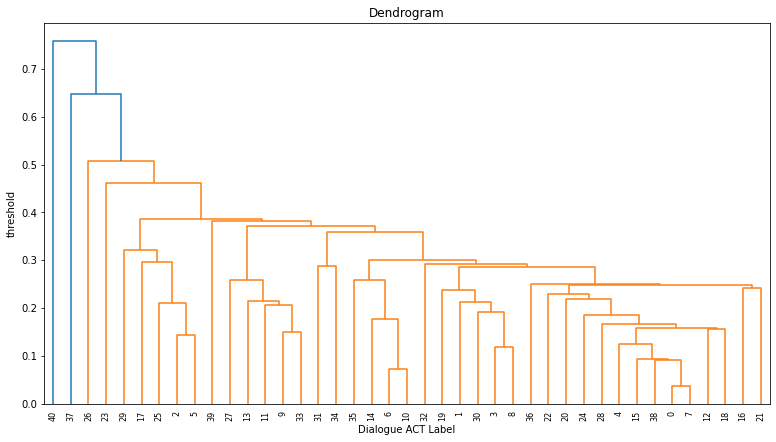

complete 0.626


<Figure size 432x288 with 0 Axes>

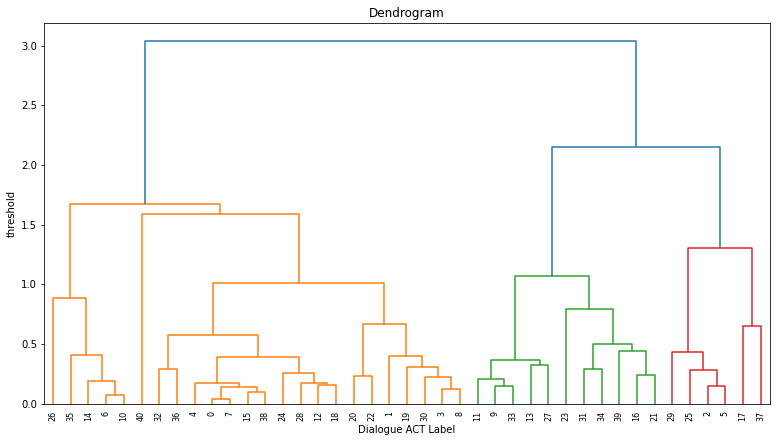

average 0.773


<Figure size 432x288 with 0 Axes>

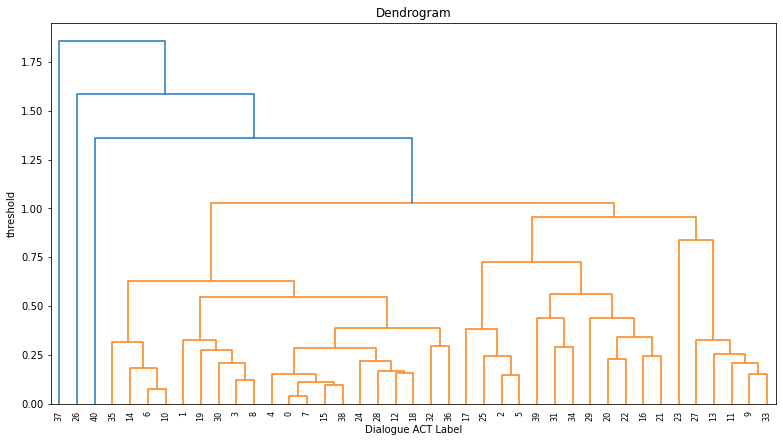

weighted 0.612


<Figure size 432x288 with 0 Axes>

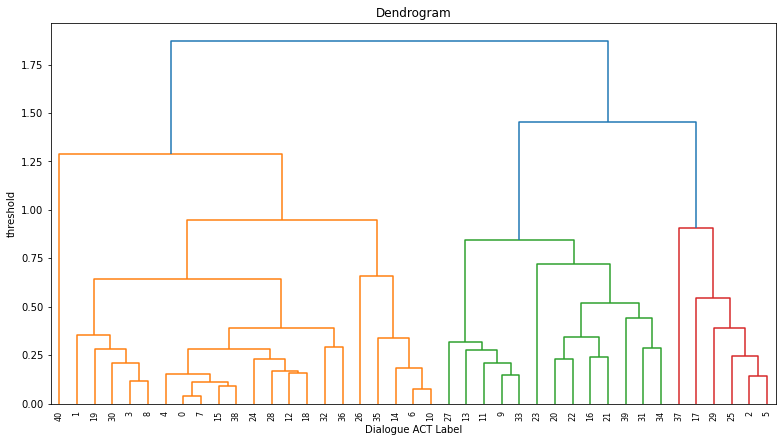

centroid 0.765


<Figure size 432x288 with 0 Axes>

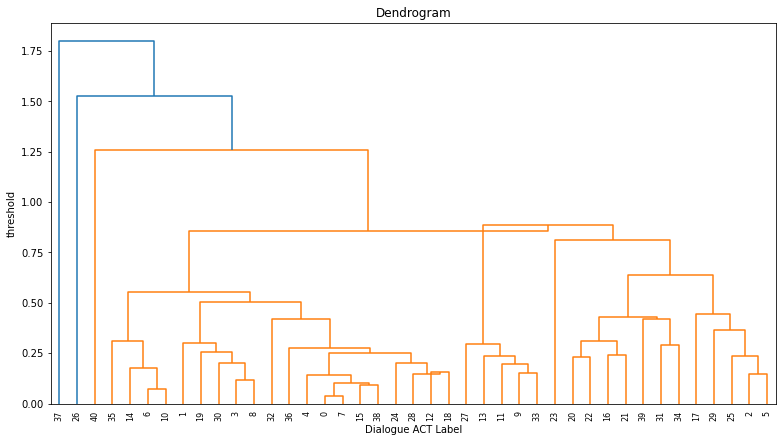

median 0.621


<Figure size 432x288 with 0 Axes>

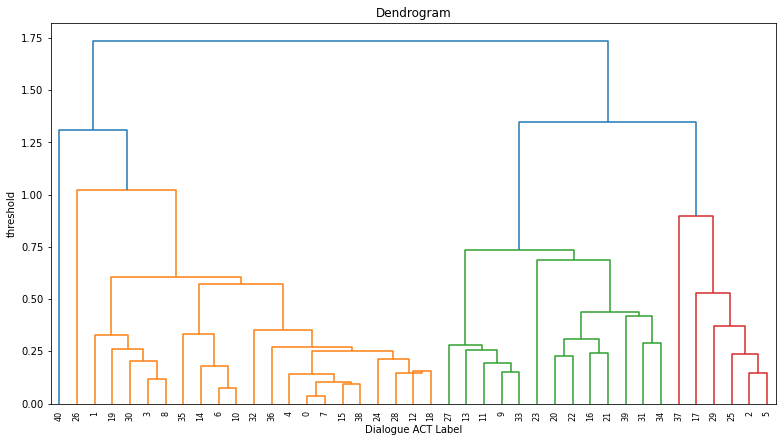

ward 0.579


<Figure size 432x288 with 0 Axes>

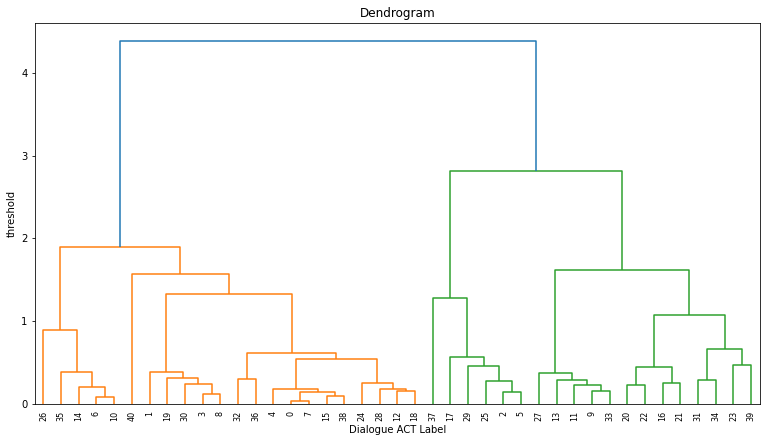

<Figure size 432x288 with 0 Axes>

In [49]:
methods = ["single", "complete", "average", "weighted","centroid", "median", "ward"]

for method in methods:
    S = pdist(result)
    Z = linkage(S, method=method)
    fig = plt.figure(figsize=(13, 7))
    ax = fig.add_subplot(1, 1, 1, title="Dendrogram")
    dendrogram(Z)
    c, d = cophenet(Z,S)
    print("{0} {1:.3f}".format(method, c))
    ax.set_xlabel("Dialogue ACT Label")
    # y 軸のラベルを設定する。
    ax.set_ylabel("threshold")
    plt.show()
    plt.savefig(t_SNE_path + "SwDA_hierarchy_dendrogram_Responce_Mean_{}_AllLabel.png".format(method))